<a href="https://colab.research.google.com/github/ab-sa/Statistical-Machine-Learning-2/blob/main/Lecture13_%20ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, BaggingRegressor, GradientBoostingClassifier, GradientBoostingRegressor

In [2]:
Credit = pd.read_csv('Credit.csv')
Credit['Balance_multi'] = pd.cut(Credit.Balance, bins=[-1,300,700,2000],labels=[0,1,2])
Credit = Credit.drop(['ID', 'Limit', 'Rating'], axis=1)
print('Dimension of the data: ' + str(Credit.shape))
print(Credit.head())
print(Credit['Balance_multi'].value_counts(normalize=True))

Dimension of the data: (400, 10)
    Income  Cards  Age  Education  Gender Student Married  Ethnicity  Balance  \
0   14.891      2   34         11    Male      No     Yes  Caucasian      333   
1  106.025      3   82         15  Female     Yes     Yes      Asian      903   
2  104.593      4   71         11    Male      No      No      Asian      580   
3  148.924      3   36         11  Female      No      No      Asian      964   
4   55.882      2   68         16    Male      No     Yes  Caucasian      331   

  Balance_multi  
0             1  
1             2  
2             1  
3             2  
4             1  
0    0.4000
2    0.3475
1    0.2525
Name: Balance_multi, dtype: float64


**Data spliting**: for both classification and regression

In [3]:
X = pd.get_dummies(Credit.drop(['Balance_multi', 'Balance'], axis=1))
y_mult = Credit['Balance_multi']
y_cont = Credit['Balance']
x_train, x_test, y_mult_train, y_mult_test = train_test_split(X, y_mult, test_size=0.2, random_state=0)
x_train, x_test, y_cont_train, y_cont_test = train_test_split(X, y_cont, test_size=0.2, random_state=0)

**Ensemble trees: Bagging** for classification

In [4]:
# define the model
clf_bagg = BaggingClassifier(n_estimators = 100, random_state = 0)
# Train the model on training data
clf_bagg.fit(x_train, y_mult_train)

# Use the forest's predict method on the test data
clf_bagg_preds = clf_bagg.predict(x_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_mult_test, clf_bagg_preds)))

Model accuracy score: 0.4250


**Ensemble trees: Bagging** for regression

In [5]:
# define the model
reg_bagg = BaggingRegressor(n_estimators = 100, random_state = 0)
# Train the model on training data
reg_bagg.fit(x_train, y_cont_train)

# Use the forest's predict method on the test data
reg_bagg_preds = reg_bagg.predict(x_test)
print('MSPE: ', mean_squared_error(y_cont_test, reg_bagg_preds))

MSPE:  166098.31333749997


**Ensemble trees: Random Forest** for classification

In [6]:
# Instantiate model with 1000 decision trees
clf_rf = RandomForestClassifier(n_estimators = 1000, random_state = 0)
# Train the model on training data
clf_rf.fit(x_train, y_mult_train)

# Use the forest's predict method on the test data
clf_rf_preds = clf_rf.predict(x_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_mult_test, clf_rf_preds)))

Model accuracy score: 0.5625


**Ensemble trees: Random Forest** for regreession

In [7]:
# Instantiate model with 1000 decision trees
reg_rf = RandomForestClassifier(n_estimators = 1000, random_state = 0)
# Train the model on training data
reg_rf.fit(x_train, y_cont_train)

# Use the forest's predict method on the test data
reg_rf_preds = reg_rf.predict(x_test)
print('MSPE: ', mean_squared_error(y_cont_test, reg_rf_preds))

MSPE:  322242.525


**Tune a RF classifier:**

In [8]:
Parameter_Trials = {'max_features':[1,2,3],  # equivalent to R "mtry" parameter
                    'min_samples_leaf':[1,3,5,7,10]  # equivalent to R "nodesize" parameter
                   }

# Creating the RF model
RF_mod = RandomForestClassifier()

# Creating the Grid search space
grid_search = GridSearchCV(estimator=RF_mod, param_grid=Parameter_Trials, cv=5)

# Running Grid Search for different paramenters
grid_search.fit(X, y_mult)

# printing the best parameters
print('\n#### Best hyperparamters ####')
print(grid_search.best_params_)


#### Best hyperparamters ####
{'max_features': 2, 'min_samples_leaf': 10}


MSPE:  [0.4425 0.49   0.5175 0.495  0.5    0.455  0.485  0.4975 0.5075 0.5275
 0.465  0.4975 0.49   0.52   0.5125]
MSPE SE:  [0.0203101  0.04286607 0.04513868 0.03409545 0.04257347 0.02318405
 0.03482097 0.03824265 0.04373214 0.0266927  0.01457738 0.0242384
 0.03824265 0.03316625 0.0295804 ]


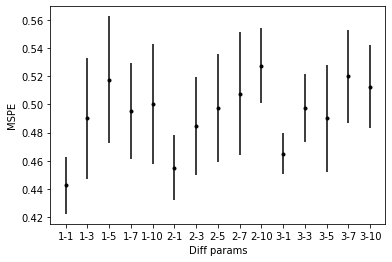

In [9]:
print('MSPE: ', grid_search.cv_results_['mean_test_score'])
print('MSPE SE: ', grid_search.cv_results_['std_test_score'])

params_list = [str(d['max_features']) + '-' + str(d['min_samples_leaf']) for d in grid_search.cv_results_['params']]
fig, ax = plt.subplots()
ax.errorbar(params_list, grid_search.cv_results_['mean_test_score'], yerr=grid_search.cv_results_['std_test_score'], fmt='.k')
plt.xlabel("Diff params")
plt.ylabel("MSPE")
plt.show()

**Ensemble trees: Gradient Boosting** for classification

In [12]:
# Instantiate model with 1000 decision trees
clf_gb = GradientBoostingClassifier(n_estimators = 1000, random_state = 0)
# Train the model on training data
clf_gb.fit(x_train, y_mult_train)

# Use the forest's predict method on the test data
clf_gb_preds = clf_gb.predict(x_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_mult_test, clf_gb_preds)))

Model accuracy score: 0.3875


**Ensemble trees: Gradient Boosting** for regression

In [15]:
# Instantiate model with 1000 decision trees
reg_gb = GradientBoostingRegressor(n_estimators = 1000, random_state = 0)
# Train the model on training data
reg_gb.fit(x_train, y_cont_train)

# Use the forest's predict method on the test data
reg_gb_preds = reg_gb.predict(x_test)
print('MSPE: ', mean_squared_error(y_cont_test, reg_gb_preds))

MSPE:  250118.83087738775
